In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mondejar/mitbih-database 
!mkdir ecg
%cd ecg
!unzip ../mitbih-database.zip
!unzip mitbih_database.zip

In [0]:
!pip install wfdb
import pywt
import pdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as ss
import wfdb
import wfdb.processing as pr

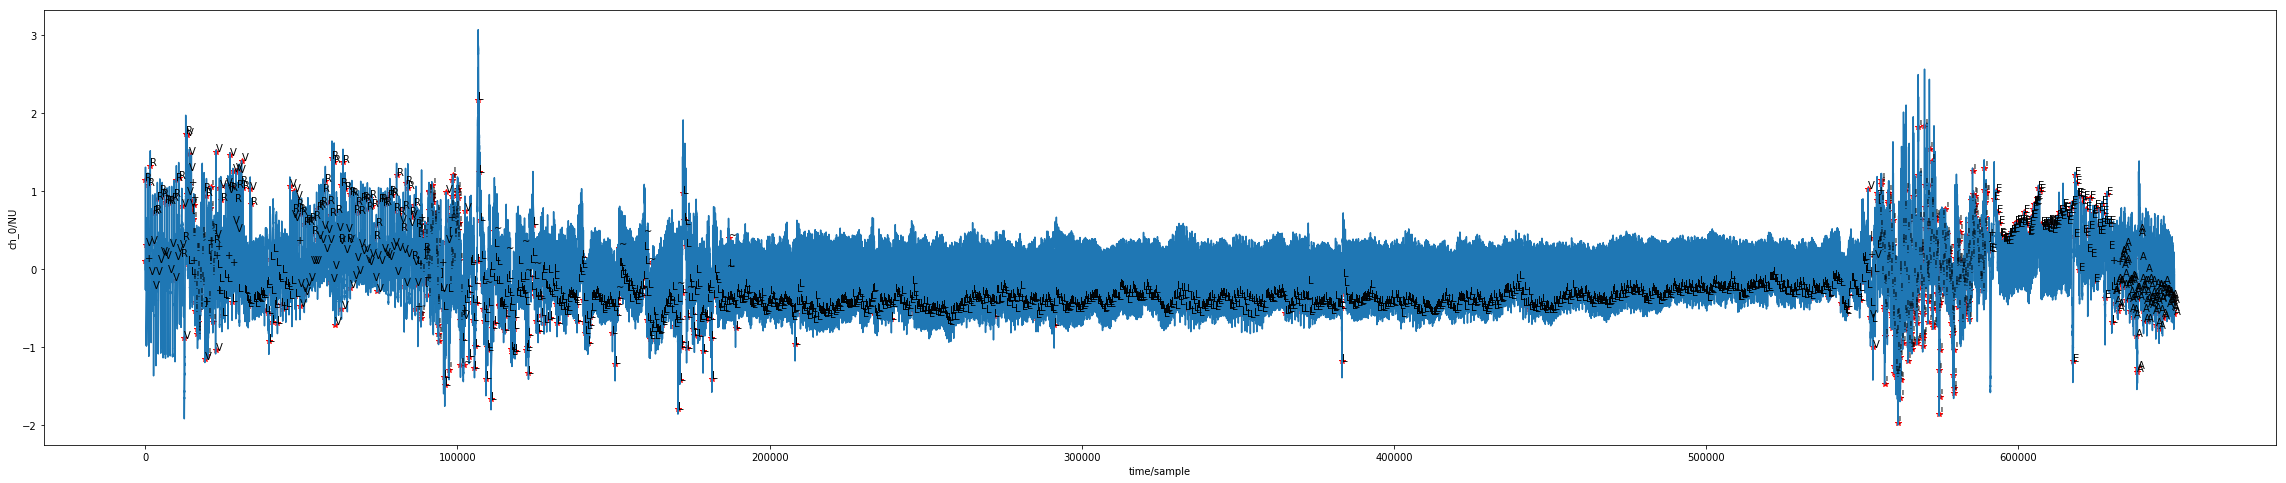

In [0]:
cut = 650000
fr = 1
num = '207'
record, fields = wfdb.rdsamp(num, pb_dir='mitdb', sampfrom=fr)
ann = wfdb.rdann(num, extension='atr', pb_dir='mitdb', sampfrom=fr)
wfdb.plot_items(signal=record[:,1], ann_samp=[ann.sample], ann_sym=[ann.symbol], figsize=(40,8))

In [0]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [0]:
xqrs = pr.gqrs_detect(record[:,0], fs=fields['fs'])
#xqrs.detect()


In [0]:
|!wget https://www.physionet.org/static/published-projects/chfdb/bidmc-congestive-heart-failure-database-1.0.0.zip
!unzip bidmc-congestive-heart-failure-database-1.0.0.zip\
%cd files

TypeError: ignored

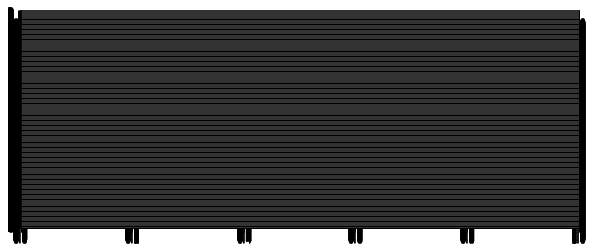

In [0]:
sl=slice(1, 1000)
wfdb.plot_items(signal=record.p_signal[sl],
                    ann_samp=ann.sample[sl],
                    title='MIT-BIH Record 100', time_units='seconds',
                    figsize=(10,4), ecg_grids='all')

In [0]:
ann.

array([      22,      176,      332, ..., 17792633, 17792820, 17792941])

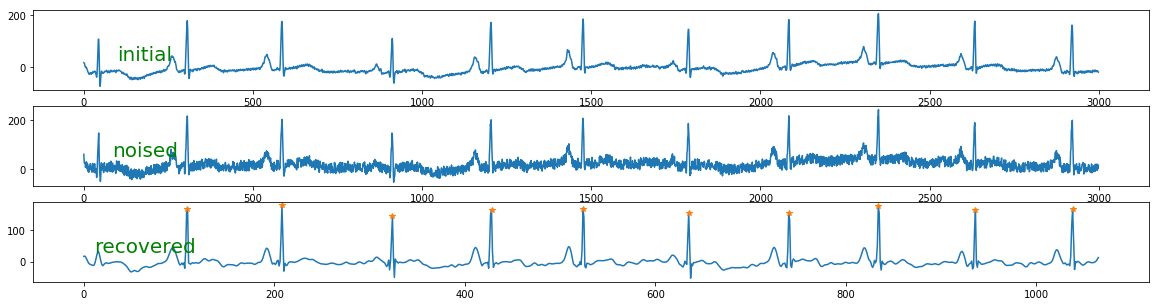

In [0]:
# RUN FUNCTION
dat = pd.read_csv('222.csv')
sig = dat.iloc[:,1].to_numpy();
fs = 360
fs_new = 128
cut = sig[22000:25000]
# run function
std=44
filt, peaks = process(cut+np.random.rand(len(cut))*std, fs, fs_new)

f,a=plt.subplots(3,1,figsize=(20,5))
a[0].plot(cut-np.mean(cut))
a[0].title.set_text('initial')
a[0].title.set_position((0.1,0.3))
a[0].title.set_color('green')
a[0].title.set_size(20)
a[1].plot(cut+np.random.rand(len(cut))*std-np.mean(cut))
a[1].title.set_text('noised')
a[1].title.set_position((0.1,0.3))
a[1].title.set_color('green')
a[1].title.set_size(20)
a[2].plot(filt)
a[2].plot(peaks,filt[peaks],'*')  
a[2].title.set_text('recovered')
a[2].title.set_position((0.1,0.3))
a[2].title.set_color('green')
a[2].title.set_size(20)

In [0]:
# DEFINE FUNCTION
def process(proc, fs_old, fs_new):
  fs_def = 128
  step = 10000   # length of chunk
  lvl = 7
  lvl_ch = 4
  win = 30
  smooth_r = 5
  peaks = np.zeros(0, np.int32)
  recs = np.zeros(0)
  if len(proc) < step:
    struc = [proc]
  else:
    struc = np.array_split(proc,len(proc)//step)
  
  #-----------NORM_CHUNK---------------
  for ch in np.arange(len(struc)):
    i=0
    proc = struc[ch]
    proc = ss.resample(proc, int(len(proc)*fs_new/fs_old))
    coef = modwt(proc, 'db2', lvl)
    cf = np.zeros((lvl, len(coef[0])))
    for i in range(0,lvl):
      pks = ss.find_peaks(coef[i], distance=fs_new)
      cf[i,:] = coef[i]/np.median(coef[i][pks[0]])
    
    #-------DETECT_PEAKS----------------------
    prom_peaks = np.zeros(0, np.int32)
    while i < len(proc)-win-1:
      maxs = []
      cond = []      
      wn = slice(i, i+win) 
      for j in range(1,lvl_ch):
        maxs.append(np.max(cf[j][wn]))    
      max_loc = np.argmax(cf[1:lvl_ch][wn],axis=1)
      shifts = np.diff(max_loc)
      argmax_wav = np.argmax(cf[1][wn])
      argmax_sig = np.argmax(proc[i:i+argmax_wav+1]) + i      
      cond.append( any(p < .5 for p in maxs) )
      cond.append( np.sum(maxs) < lvl_ch/2 )
      cond.append( proc[argmax_sig] < proc[argmax_sig+1])
      cond.append( proc[argmax_sig]-np.median(proc) < np.std(proc) )
      if any(cond):
        i += 1
      else:  
        prom_peaks = np.append(prom_peaks, argmax_sig)
        i += win
        
    #--------FILTER_NOISE_AND_BIAS------------------    
    coef_new = np.zeros((3,len(coef[0])))
    for pk in prom_peaks:
      if pk-smooth_r*2 >=0 and pk+smooth_r*2 < len(coef[1])-1:
        coef_new[0][pk-smooth_r+2:pk+smooth_r] = coef[0][pk-smooth_r+2:pk+smooth_r]
        coef_new[1][pk-smooth_r*2+4:pk+smooth_r*2] = coef[1][pk-smooth_r*2+4:pk+smooth_r*2]

    # set wavelet coefs to 0
    if np.median(np.abs(coef[0])) > 1.9:
      coef[1] = coef_new[1] 
    coef[0] = coef_new[0]  
    coef[-1] = 0
    
    rec = imodwt(coef, 'db2')
    recs = np.append(recs, rec)
    peaks = np.append(peaks, prom_peaks + ch*(len(proc)) )

    #-----------return appended chunks------------
  return recs, peaks

In [0]:
# SUPPLY FUNCTIONS
def upArrow_op(li, j):
    if j == 0:
        return [1]
    N = len(li)
    li_n = np.zeros(2 ** (j - 1) * (N - 1) + 1)
    for i in range(N):
        li_n[2 ** (j - 1) * i] = li[i]
    return li_n


def period_list(li, N):
    n = len(li)
    # append [0 0 ...]
    n_app = N - np.mod(n, N)
    li = list(li)
    li = li + [0] * n_app
    if len(li) < 2 * N:
        return np.array(li)
    else:
        li = np.array(li)
        li = np.reshape(li, [-1, N])
        li = np.sum(li, axis=0)
        return li


def circular_convolve_mra(h_j_o, w_j):
    ''' calculate the mra D_j'''
    N = len(w_j)
    l = np.arange(N)
    D_j = np.zeros(N)
    for t in range(N):
        index = np.mod(t + l, N)
        w_j_p = np.array([w_j[ind] for ind in index])
        D_j[t] = (np.array(h_j_o) * w_j_p).sum()
    return D_j


def circular_convolve_d(h_t, v_j_1, j):
    '''
    jth level decomposition
    h_t: \tilde{h} = h / sqrt(2)
    v_j_1: v_{j-1}, the (j-1)th scale coefficients
    return: w_j (or v_j)
    '''
    N = len(v_j_1)
    L = len(h_t)
    w_j = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t - 2 ** (j - 1) * l, N)
        v_p = np.array([v_j_1[ind] for ind in index])
        w_j[t] = (np.array(h_t) * v_p).sum()
    return w_j


def circular_convolve_s(h_t, g_t, w_j, v_j, j):
    '''
    (j-1)th level synthesis from w_j, w_j
    see function circular_convolve_d
    '''
    N = len(v_j)
    L = len(h_t)
    v_j_1 = np.zeros(N)
    l = np.arange(L)
    for t in range(N):
        index = np.mod(t + 2 ** (j - 1) * l, N)
        w_p = np.array([w_j[ind] for ind in index])
        v_p = np.array([v_j[ind] for ind in index])
        v_j_1[t] = (np.array(h_t) * w_p).sum()
        v_j_1[t] = v_j_1[t] + (np.array(g_t) * v_p).sum()
    return v_j_1


def modwt(x, filters, level):
    '''
    filters: 'db1', 'db2', 'haar', ...
    return: see matlab
    '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    wavecoeff = []
    v_j_1 = x
    for j in range(level):
        w = circular_convolve_d(h_t, v_j_1, j + 1)
        v_j_1 = circular_convolve_d(g_t, v_j_1, j + 1)
        wavecoeff.append(w)
    wavecoeff.append(v_j_1)
    return np.vstack(wavecoeff)


def imodwt(w, filters):
    ''' inverse modwt '''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    h_t = np.array(h) / np.sqrt(2)
    g_t = np.array(g) / np.sqrt(2)
    level = len(w) - 1
    v_j = w[-1]
    for jp in range(level):
        j = level - jp - 1
        v_j = circular_convolve_s(h_t, g_t, w[j], v_j, j + 1)
    return v_j


def modwtmra(w, filters):
    ''' Multiresolution analysis based on MODWT'''
    # filter
    wavelet = pywt.Wavelet(filters)
    h = wavelet.dec_hi
    g = wavelet.dec_lo
    # D
    level, N = w.shape
    level = level - 1
    D = []
    g_j_part = [1]
    for j in range(level):
        # g_j_part
        g_j_up = upArrow_op(g, j)
        g_j_part = np.convolve(g_j_part, g_j_up)
        # h_j_o
        h_j_up = upArrow_op(h, j + 1)
        h_j = np.convolve(g_j_part, h_j_up)
        h_j_t = h_j / (2 ** ((j + 1) / 2.))
        if j == 0: h_j_t = h / np.sqrt(2)
        h_j_t_o = period_list(h_j_t, N)
        D.append(circular_convolve_mra(h_j_t_o, w[j]))
    # S
    j = level - 1
    g_j_up = upArrow_op(g, j + 1)
    g_j = np.convolve(g_j_part, g_j_up)
    g_j_t = g_j / (2 ** ((j + 1) / 2.))
    g_j_t_o = period_list(g_j_t, N)
    S = circular_convolve_mra(g_j_t_o, w[-1])
    D.append(S)
    return np.vstack(D)


if __name__ == '__main__':
    s1 = np.arange(10)
    ws = modwt(s1, 'db2', 3)
    s1p = imodwt(ws, 'db2')
    mra = modwtmra(ws, 'db2')


NameError: ignored